# Advection using TVD Flux Limiters
## CH EN 6355 - Computational Fluid Dynamics
**Prof. Tony Saad (<a>www.tsaad.net</a>) <br/>
slides at: <a>www.tsaad.net</a><br/>
Department of Chemical Engineering <br/>
University of Utah**
<hr/>

Here, we will implement the k-scheme or kappa-schemes for advection. It is easiest to implement this scheme since for different values of k, we recover all sorts of high-order flux approximations. We will assume a positive advecting velocity for illustration purposes.

We are solving the constant speed advection equation given by
\begin{equation}
u_t = - c u_x = - F_x;\quad F = cu
\end{equation}
We will use a simple Forward Euler explicit method. Using a finite volume integration, we get
\begin{equation}
u_i^{n+1} = u_i^n - \frac{\Delta t}{\Delta x} (F_{i+\tfrac{1}{2}}^n - F_{i-\tfrac{1}{2}}^n)
\end{equation}
Our TVD formulation is based on a finite volume discretization with face values for the dependent variable given by:
\begin{equation}
{\phi _f} = {\phi _{\rm{C}}} + {1 \over 2}\psi ({r_f})\left( {{\phi _{\rm{D}}} - {\phi _{\rm{C}}}} \right)
\end{equation}
where $\psi$ is the limiter function.

In [1]:
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams['animation.html'] = 'html5'
from matplotlib import cm

In [2]:
def step(x,x0):
    x0 = 0.6
    x1 = 0.8
    result = x - x0
    result[x-x1<x1] = 1.0            
    result[x<x0] = 0.0
    result[x>x1] = 0.0  
    return result

def gaussian(x,x0):
    s = 0.08
    s = s*s
    result = np.exp( -(x-x0)**2/s)
    return result

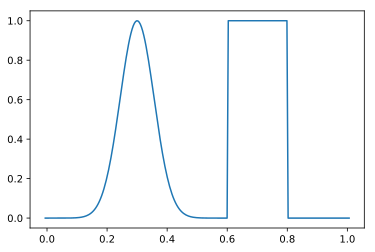

In [3]:
L = 1.0
n = 256 # cells
dx = L/n # n intervals
x = np.linspace(-3*dx/2, L + 3*dx/2, n+4) # include ghost cells - we will include 2 ghost cells on each side for high order schemes

# create arrays
phi = np.zeros(n+4) # cell centered quantity
f = np.zeros(n+4+1) # flux
u = np.ones(n+4+1) # velocity field - assumed to live on faces same as flux

x0 = 0.3
# u0 = np.zeros(N + 2)
# u0[1:-1] = np.sin(2*np.pi*x)
# u0 = np.zeros(N)
# phi0 = np.sin(np.pi*x)
phi0 = gaussian(x,x0) + step(x,x0)
# u0 = triangle(x,0.5,0.75,1)
# u0[0:N//2] = 1.0
plt.plot(x,phi0)

In [4]:
cfl = 0.5
c = 1.0
dt = cfl*dx/abs(c)
print('dt=',dt)
print('dx=',dx)
# μ = 0.001
# dt = 0.02

dt= 0.001953125
dx= 0.00390625


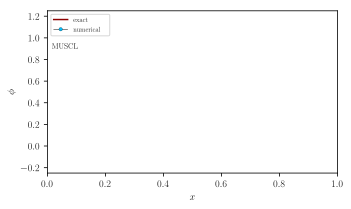

In [7]:
# finite volume implementation with arrays for fluxes
t = 0
tend = L/abs(c)
sol = []
sol.append(phi0)
ims = []

fig = plt.figure(figsize=[5,3],dpi=200)
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.size"] = 10
plt.rc('text', usetex=True)

# plt.grid()
plt.xlim([0.,L])
plt.ylim([-0.25,1.25])
plt.xlabel('$x$')
plt.ylabel('$\phi$')
plt.tight_layout()
# plot initial condition
plt.plot(x,phi0,'darkred',animated=True)

schemename='Bounded CD'

i = 0
while t < tend:    
    phin = sol[-1]

    # impose periodic conditions
    phin[-2] = phin[2]
    phin[-1] = phin[3]    
    phin[0] = phin[-4]        
    phin[1] = phin[-3]            


    if (i%2==0):
        shift =int(np.ceil(c*(t-dt)/dx))
        im = plt.plot(x[2:-2], np.roll(phin[2:-2], -shift) ,'k-o',markevery=2,markersize=3.5,markerfacecolor='deepskyblue',
             markeredgewidth=0.25, markeredgecolor='k',linewidth=0.45, animated=True)
        ims.append(im)
        
    phi = np.zeros_like(phi0)
    
    # predictor - take half a step and use upwind
    # du/dt = -c*du/dx
    if c >= 0:
        ϕc = phin[1:-2] # phi upwind
    else:
        ϕc = phin[2:-1] # phi upwind
    
    f[2:-2] = c*ϕc
    phi[2:-2] = phin[2:-2] - dt/2.0/dx*(f[3:-2] - f[2:-3])
    phi[-2] = phi[2]
    phi[-1] = phi[3]    
    phi[0] = phi[-4]        
    phi[1] = phi[-3]                

        # du/dt = -c*du/dx
    if c >= 0:
        ϕc = phi[1:-2] # phi upwind
        ϕu = phi[:-3]  # phi far upwind
        ϕd = phi[2:-1] # phi downwind
    else:
        ϕc = phi[2:-1] # phi upwind
        ϕu = phi[3:]  # phi far upwind
        ϕd = phi[1:-2] # phi downwind

    # compute r - ratio of successive gradients
    numerator = ϕc - ϕu    
    denominator = ϕd - ϕc
    # find the locations where the denominator is > 1e-12 - that's where we will do the divisions. otherwise, set phi to 1
    divideloc = np.where(np.abs(denominator) > 1e-6)
    i1 = np.where(numerator < 1e-12)
    r = np.ones_like(ϕc)
    r[divideloc] = numerator[divideloc]/denominator[divideloc]

    # compute face values - these actually live on the faces
    ϕf = np.zeros_like(ϕc)
    
#     # bounded CD    
#     schemename='Bounded CD'
#     ϕftilde = 0.5 + 0.5*ϕctilde
    
#     # minmod
#     schemename='MinMod'
#     psi = np.maximum(0,np.minimum(1,r))
    
#     # SUPERBEE
#     schemename='Superbee'
#     psi = np.maximum(0, np.minimum(1.0,2.0*r), np.minimum(2.0,r))

    # MUSCL
    schemename='MUSCL'
    psi = np.maximum(0.0, np.minimum(np.minimum(2*r, (r+1)/2.0), 2.0))

    # now retrieve phif from phiftilde
    ϕf = ϕc + 0.5*psi*(ϕd - ϕc)
    f[2:-2] = ϕf
    f = c*f # multiply the flux by the velocity
    # advect
    phi[2:-2] = phin[2:-2] - dt/dx*(f[3:-2] - f[2:-3]) #+ dt/dx/dx*diffusion
    t += dt    
    i+=1
    sol.append(phi)


plt.annotate(schemename, xy=(0.5, 0.8), xytext=(0.015, 0.9),fontsize=8)
plt.legend(('exact','numerical'),loc='upper left',fontsize=7)
ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True,
                                repeat_delay=1000)

# ani.save('k-scheme-'+str(k)+'.mp4',dpi=300,fps=24)

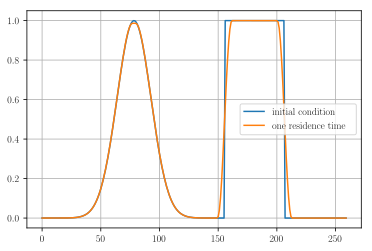

In [10]:
plt.plot(sol[0], label='initial condition')
plt.plot(sol[-1], label='one residence time')
plt.legend()
plt.grid()

In [8]:
ani

# Create Animation in Moving Reference Frame

done!


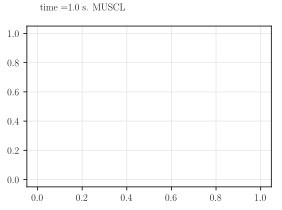

In [9]:
"""
Create Animation in Moving Reference Frame
"""
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
matplotlib.use("Agg")
fig, ax = plt.subplots(figsize=(4,3),dpi=150) 
ax.grid(True,color='0.9')
f0 = sol[0]
line0, = ax.plot(x[2:-2], f0[2:-2] ,'r-',linewidth=0.75, animated=True)
line1, = ax.plot(x[2:-2], f0[2:-2] ,'k-o',markevery=2,markersize=3.5,markerfacecolor='deepskyblue',
             markeredgewidth=0.25, markeredgecolor='k',linewidth=0.45, animated=True)


ann = ax.annotate('time ='+str(round(t,4))+' s.' + '\t'+ schemename, xy=(0,0), xytext=(40, 200),xycoords='figure points')
plt.tight_layout()
# plt.locator_params(axis='x', nbins=15)

# def animate(i):
# #     xt = x - i*c*dt/dx
# #     line.set_xdata(xt)
# #     ax.axes.set_xlim(xt[0],xt[-1])
# #     ax.grid()
# #     line.set_ydata(np.sin(xt))  # update the data
# #     line.set_ydata(sol[i])
#     print('time=',i*dt)
#     shift =int(np.ceil(i*c*dt/dx))
#     f = sol[i]
#     line.set_ydata(np.roll(f, -shift))
# #     im = plt.plot(x[2:-2], np.roll(phin[2:-2], -shift) ,'k-o',markevery=2,markersize=3.5,markerfacecolor='deepskyblue',
# #          markeredgewidth=0.25, markeredgecolor='k',linewidth=0.45, animated=True)
#     return line,

def animate_moving(i):
    print('time=',i*dt)
    t = i*dt
    xt = x + i*1.1*c*dt
    line0.set_xdata(xt[2:-2])
    line1.set_xdata(xt[2:-2])    
    ax.axes.set_xlim(xt[0],0.0*dx + xt[-1])
    f = sol[i]
    ax.axes.set_ylim(-0.1,1.1*max(f))
    ann.set_text('time ='+str(round(t,4))+'s (' + str(i)+ ').\t' + schemename)
    shift =int(np.ceil(i*c*dt/dx))
    line1.set_ydata(np.roll(f[2:-2], -shift))

    f0 = sol[0]
    line0.set_ydata(f0[2:-2])
    return line0,line1


# Init only required for blitting to give a clean slate.
def init():
    line0.set_ydata(np.ma.array(x[2:-2], mask=True))
    line1.set_ydata(np.ma.array(x[2:-2], mask=True))    
    return line0,line1

ani = animation.FuncAnimation(fig, animate_moving, np.arange(0,len(sol),2*int(1.0/cfl)), init_func=init,
                              interval=20, blit=False)
print('done!')

In [60]:
ani.save(schemename+'_TVD.mp4',fps=24,dpi=300)

time= 0.0
time= 0.0078125
time= 0.015625
time= 0.0234375
time= 0.03125
time= 0.0390625
time= 0.046875
time= 0.0546875
time= 0.0625
time= 0.0703125
time= 0.078125
time= 0.0859375
time= 0.09375
time= 0.1015625
time= 0.109375
time= 0.1171875
time= 0.125
time= 0.1328125
time= 0.140625
time= 0.1484375
time= 0.15625
time= 0.1640625
time= 0.171875
time= 0.1796875
time= 0.1875
time= 0.1953125
time= 0.203125
time= 0.2109375
time= 0.21875
time= 0.2265625
time= 0.234375
time= 0.2421875
time= 0.25
time= 0.2578125
time= 0.265625
time= 0.2734375
time= 0.28125
time= 0.2890625
time= 0.296875
time= 0.3046875
time= 0.3125
time= 0.3203125
time= 0.328125
time= 0.3359375
time= 0.34375
time= 0.3515625
time= 0.359375
time= 0.3671875
time= 0.375
time= 0.3828125
time= 0.390625
time= 0.3984375
time= 0.40625
time= 0.4140625
time= 0.421875
time= 0.4296875
time= 0.4375
time= 0.4453125
time= 0.453125
time= 0.4609375
time= 0.46875
time= 0.4765625
time= 0.484375
time= 0.4921875
time= 0.5
time= 0.5078125
time= 0.51562

In [11]:
import urllib
import requests
from IPython.core.display import HTML
def css_styling():
    styles = requests.get("https://raw.githubusercontent.com/saadtony/NumericalMethods/master/styles/custom.css")
    return HTML(styles.text)
css_styling()